In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import os
import json
import zipfile
import random
import numpy as np
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **테스트 데이터셋 준비**

**이미지 파일 압축 해제**
- 본인 경로를 제대로 설정했는지 확인
- 세션 디스크에 `data > train` 폴더를 만들어두고 압축 해제 진행하셔야 합니다..!
  - 세션 디스크 내 임시 경로로, 드라이브 x

```
!unzip (데이터 경로) -d (압축 해제할 경로)
```

In [3]:
!unzip /content/drive/MyDrive/6th-project/final/data/test.zip -d /content/data/test

Archive:  /content/drive/MyDrive/6th-project/final/data/test.zip
  inflating: /content/data/test/image_1.jpg  
  inflating: /content/data/test/image_10.jpg  
  inflating: /content/data/test/image_100.jpg  
  inflating: /content/data/test/image_1000.jpg  
  inflating: /content/data/test/image_1001.jpg  
  inflating: /content/data/test/image_1002.jpg  
  inflating: /content/data/test/image_1003.jpg  
  inflating: /content/data/test/image_1004.jpg  
  inflating: /content/data/test/image_1005.jpg  
  inflating: /content/data/test/image_1006.jpg  
  inflating: /content/data/test/image_1007.jpg  
  inflating: /content/data/test/image_1008.jpg  
  inflating: /content/data/test/image_1009.jpg  
  inflating: /content/data/test/image_101.jpg  
  inflating: /content/data/test/image_1010.jpg  
  inflating: /content/data/test/image_1011.jpg  
  inflating: /content/data/test/image_1012.jpg  
  inflating: /content/data/test/image_1013.jpg  
  inflating: /content/data/test/image_1014.jpg  
  inflating

In [4]:
### annotations 파일 준비

coco_test_path = '/content/drive/MyDrive/6th-project/final/data/coco_test.json'

In [5]:
### Custom Dataset 클래스 정의

class FashionDataset(Dataset):
  def __init__(self, annotation_file, image_dir, transform = None):
    with open(annotation_file, 'r') as f:
      self.coco_data = json.load(f)
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.coco_data['annotations'])

  def __getitem__(self, idx):
    ## 속성 정보
    annotation = self.coco_data['annotations'][idx]

    ## 이미지
    image_id = annotation['image_id']

    image_info = next((img for img in self.coco_data['images'] if img['id'] == image_id), None)
    image_path = os.path.join(self.image_dir, image_info['file_name'])

    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    ## 캡션
    caption = annotation['caption']

    return image, caption

In [6]:
# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [7]:
test_dataset = FashionDataset(annotation_file = coco_test_path,
                               image_dir = '/content/data/test',
                               transform = transform)

In [8]:
### DataLoader 설정

test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

## **모델 불러오기**

In [9]:
!pip install peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [10]:
from transformers import BlipForConditionalGeneration
from peft import get_peft_model, LoraConfig

# 1. BLIP 모델 불러오기
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [11]:
### target layer 가져오기
# 특정한 pattern으로 탐색

def get_target_modules(model, patterns):
  target_modules = []
  for name, module in model.named_modules():
    for pattern in patterns:
      if pattern in name:
        target_modules.append(name)
  return target_modules

In [12]:
## 예시
# 조합에 따라 바꿔야함(layer 찍어서 구조 확인해보기)

decoder_patterns = ["self.query", "self.key", "self.value", "intermediate.dense", "output.dense"]
#encoder_patterns = ["self_attn.qkv", "mlp.fc"]

#encoder_modules = get_target_modules(model, encoder_patterns)[-18:] # 마지막 6개 layer만 가져오려고..
                                                                    # 조건에 따라 바꿔야 함
decoder_modules = get_target_modules(model, decoder_patterns)

target_modules = decoder_modules #+encoder_modules

In [13]:
## LoRA Configuration
lora_config = LoraConfig(
    r = 16, # LoRA의 rank
    lora_alpha = 32, # LoRA의 alpha
    lora_dropout = 0.05, # LoRA의 dropout 비율
    target_modules = target_modules,
    bias = "none"
)

In [14]:
# 2. LoRA 적용 모델 생성
peft_model = get_peft_model(model, lora_config)

# 3. 저장된 모델 상태 업데이트
model_path = '/content/drive/MyDrive/6th-project/final/model/model_trial_1.pth'
peft_model.load_state_dict(torch.load(model_path), strict=False)

# 4. 모델을 장치로 이동 및 평가 모드 설정
peft_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
peft_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): BlipForConditionalGeneration(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-23): 24 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=1024, out_features=3072, bias=True)
                (projection): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=1024, out_features=4096, bias=True)
                (fc2): Linear(in_features=4096, out_features=1024, bias=True)
              )
              (layer_

In [15]:
# 전처리기 불러오기
from transformers import BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", do_rescale = False)

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## **평가 지표 준비**

In [16]:
!git clone https://github.com/salaniz/pycocoevalcap
!pip install git+https://github.com/salaniz/pycocoevalcap.git

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (424/424), done.
  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-xmw9_xvl
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-xmw9_xvl
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=7cb7319ea5e329786c204d6898ffeef8a76a60ed35436b33934415bd7bcc083e
  Stored in directory: /tmp/pip-ephem-wheel-cache-u65c5itu/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fe

In [17]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [18]:
# 평가 지표 계산

def compute_metrics(preds, labels):
  scorers = [
      (Bleu(4), "BLEU-4"),
      (Meteor(), "METEOR"),
      (Rouge(), "ROUGE"),
      (Cider(), "CIDEr"),
      (Spice(), "SPICE")
  ]

  results = {}
  for scorer, method in scorers:
    score, _ = scorer.compute_score({i: [labels[i]] for i in range(len(labels))}, {i: [preds[i]] for i in range(len(preds))})
    results[method] = score if isinstance(score, float) else score[-1]

  return results

##**추론**

In [19]:
from tqdm import tqdm

all_preds = []
all_labels = []

with torch.no_grad():
    for images, captions in tqdm(test_loader, desc = "Testing"):
        images = images.to(peft_model.device)
        inputs = processor(images = images, text = captions, return_tensors = "pt", padding = True).to(peft_model.device)

        # Generate captions
        generated_ids = peft_model.generate(pixel_values = inputs.pixel_values, max_length = 50)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens = True)

        # Collect predictions and labels for evaluation
        all_preds.extend(generated_texts)
        all_labels.extend(captions)

Testing: 100%|██████████| 125/125 [13:52<00:00,  6.66s/it]


In [20]:
# Calculate evaluation metrics

metrics = compute_metrics(all_preds, all_labels)

print(f"BLEU: {metrics['BLEU-4']:.4f}, METEOR: {metrics['METEOR']:.4f}, ROUGE: {metrics['ROUGE']:.4f}, CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}")

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
{'testlen': 40974, 'reflen': 42564, 'guess': [40974, 38974, 36974, 34974], 'correct': [9952, 1570, 261, 50]}
ratio: 0.9626444882999493
BLEU: 0.0171, METEOR: 0.0873, ROUGE: 0.1816, CIDEr: 0.2448, SPICE: 0.0909


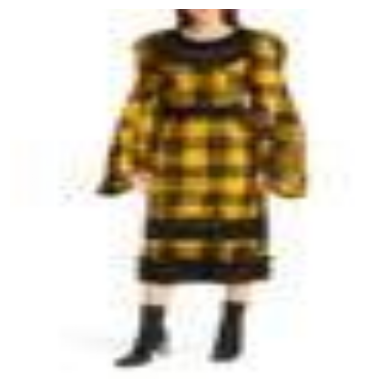

Generated: a bold plaid pattern and a bold collar add a fresh twist to this cozy sweater dress that s ready for the season
Original: victorian element seen in the covered up midi silhouette split cape sleeve and frilly ruffle reign in this austere tartan dress boasting a rebellious print


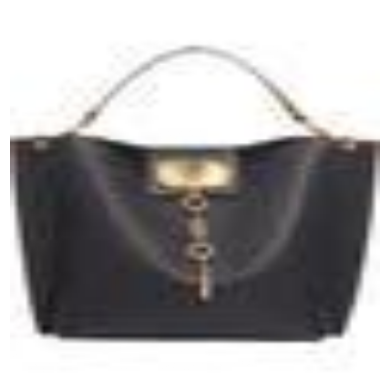

Generated: a signature hardware add a touch of class to a leather tote crafted with a smooth and smooth leather interior
Original: v logo hardware with a pendant chain double a a closure on a pebbled leather hobo featuring interchangeable strap and a handy pouch at the spacious interior


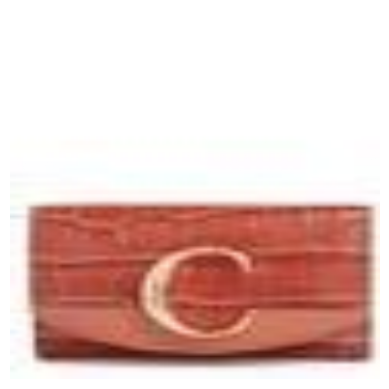

Generated: a signature c logo embossed on the front of a leather wallet crafted from a smooth smooth grained calfskin leather
Original: an oversized c shine at the flap of this sized down wallet impeccably crafted from croc embossed calfskin leather


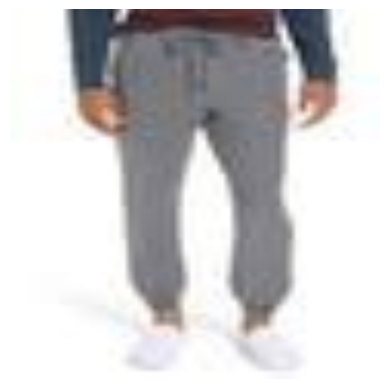

Generated: a soft and stretchy blend of wool and cotton brings a soft and comfortable look to these easy to wear sweatpants
Original: stretchy organic cotton brings supreme comfort to soft twill sweatpants done in vintage wash coloring to enhance their easy wearing appeal


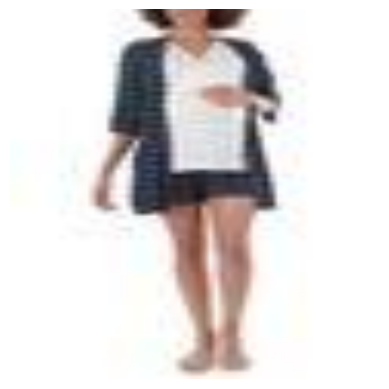

Generated: a striped cardigan is a classic take on the classic trend with a classic button down collar and a classic button down hem
Original: enjoy sweet slumber during and post pregnancy in this one-piece that includes comfy pjs a cozy robe and matching gown and hat for baby


In [21]:
import matplotlib.pyplot as plt

## 시각화 및 출력
# 예시로 5개에 대해 시각화

for i in range(5):
    image, original_caption = test_dataset[i]  # 해당 인덱스의 이미지와 캡션 가져오기
    generated_caption = all_preds[i]  # 모델이 생성한 캡션

    # 이미지 시각화
    plt.figure()
    plt.imshow(image.permute(1, 2, 0))  # 이미지 텐서를 (H, W, C)로 변환하여 출력
    plt.axis('off')
    plt.show()

    # 생성된 캡션과 원래 캡션 출력
    print(f"Generated: {generated_caption}\nOriginal: {original_caption}")